In [65]:
import pyDOE 
from scipy.stats.distributions import uniform
import numpy as np
from scipy.integrate import odeint
import pandas as pd

# Build the Hogkin-Huxley model that will generate the membrane potentials

In [44]:


class Hodgkin_Huxley_model():
    
    def __init__(self):

        ## Default parameters of the Hodgkin Huxley model
        
        self.V_rest = -65  
        self.Cm = 1        
        self.gbar_Na = 120 
        self.gbar_K = 36   
        self.gbar_L = 0.3  
        self.E_Na = 50     
        self.E_K = -77     
        self.E_l = -54.4   
        self.I_value = 150 
        
        
        
        SimulationTime = 30 #Simulation time
        dt = 0.025 # Time per step
        
        
        self.timeaxis = np.arange(0, SimulationTime + dt, dt)


    def I(self, t):
        return self.I_value

    # K channel
    def a_n(self, V):
        return 0.01*(V + 55)/(1 - np.exp(-(V + 55)/10.))

    def b_n(self, V):
        return 0.125*np.exp(-(V + 65)/80.)

    def n_f(self, n, V):
        return self.a_n(V)*(1 - n) - self.b_n(V)*n

    def n_inf(self, V):
        return self.a_n(self.V_rest)/(self.a_n(self.V_rest) + self.b_n(self.V_rest))

    def a_m(self, V):
        return 0.1*(V + 40)/(1 - np.exp(-(V + 40)/10.))

    def b_m(self, V):
        return 4*np.exp(-(V + 65)/18.)

    def m_f(self, m, V):
        return self.a_m(V)*(1 - m) - self.b_m(V)*m

    def m_inf(self, V):
        return self.a_m(self.V_rest)/(self.a_m(self.V_rest) + self.b_m(self.V_rest))
    
    def a_h(self, V):
        return 0.07*np.exp(-(V + 65)/20.)

    def b_h(self, V):
        return 1/(np.exp(-(V + 35)/10.) + 1)

    def h_f(self, h, V):
        return self.a_h(V)*(1 - h) - self.b_h(V)*h

    def h_inf(self, V):
        return self.a_h(self.V_rest)/(self.a_h(self.V_rest) + self.b_h(self.V_rest))


    def dXdt(self, X, t):
        V, h, m, n = X

        g_Na = self.gbar_Na*(m**3)*h
        g_K = self.gbar_K*(n**4)
        g_l = self.gbar_L

        dmdt = self.m_f(m, V)
        dhdt = self.h_f(h, V)
        dndt = self.n_f(n, V)

        dVdt = (self.I(t) - g_Na*(V - self.E_Na) - g_K*(V - self.E_K) - g_l*(V - self.E_l))/self.Cm

        return [dVdt, dhdt, dmdt, dndt]


    def set_parameters(self, **parameters):
        """
        Setting parameters of the hodgkin huxley model
        """
        for parameter in parameters:
            setattr(self, parameter, parameters[parameter])

    
    

    def run(self, **parameters):
        self.set_parameters(**parameters)

        self.h0 = self.h_inf(self.V_rest)
        self.m0 = self.m_inf(self.V_rest)
        self.n0 = self.n_inf(self.V_rest)

        initial_conditions = [self.V_rest, self.h0, self.m0, self.n0]
        
        X = odeint(self.dXdt, initial_conditions, self.timeaxis)
        
        values = X[:, 0]


        return self.timeaxis, values

# Data Generation

## Test run with default values

In [45]:
import matplotlib.pyplot as plt
HH = Hodgkin_Huxley_model()
t0,v0 = HH.run()

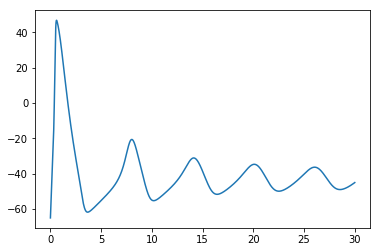

In [46]:
plt.plot(t0,v0)

## Creating parameter range

Sets up a parameter range for the input parameters. 

In [47]:
pc = 0.2 # Per cent change

# Creates list for each parameters: ["Param",Start,"range"]
parameter_list = [
                  ["Cm", 1*(1-pc), 1*(1+pc) - 1*(1-pc)],
                  ["gbar_Na", 120*(1-pc) ,120*(1+pc) - 120*(1-pc)],
                  ["gbar_K" , 36*(1-pc) ,36*(1+pc) - 36*(1-pc)],
                  ["gbar_L" , 0.3*(1-pc),0.3*(1+pc) - 0.3*(1-pc)],
                  ["E_Na", 50*(1-pc), 50*(1+pc)-50*(1-pc)], 
                  ["E_K", -77*(1+pc), -77*(1-pc)- -77*(1+pc)], 
                  ["E_l", -54.4 *(1+pc), -54.4 *(1-pc)- -54.4 *(1+pc)]]

In [51]:
parameter_list # Prints the ranges

[['Cm', 0.8, 0.3999999999999999],
 ['gbar_Na', 96.0, 48.0],
 ['gbar_K', 28.8, 14.399999999999995],
 ['gbar_L', 0.24, 0.12],
 ['E_Na', 40.0, 20.0],
 ['E_K', -92.39999999999999, 30.79999999999999],
 ['E_l', -65.28, 21.759999999999998]]

In [52]:
parameter_list = np.array(parameter_list)

## LHS design

Extracts starting position and range as seperate lists

In [81]:
names = list(parameter_list[:,0])

In [82]:
param_start = [float(n) for n in parameter_list[:,1]] # Starting value for all parameters
param_start

[0.8, 96.0, 28.8, 0.24, 40.0, -92.39999999999999, -65.28]

In [83]:
param_range = [float(n) for n in parameter_list[:,2]] # Range for all parameters
param_range

[0.3999999999999999,
 48.0,
 14.399999999999995,
 0.12,
 20.0,
 30.79999999999999,
 21.759999999999998]

Sets up the Latin Hypercube sampling

In [84]:
un = uniform(param_start,param_range) # Creates a uniform distribution for all parameters.

In [85]:
LHS = pyDOE.lhs(7,samples=3**7) # Define the Latin hypercube sampler

In [86]:
sample_space = un.ppf(LHS) # Creates the samplespace running the hypercube sampler with a uniform distribution

In [87]:
pd.DataFrame(sample_space,columns=names).describe() # Prints out parameter space

,Cm,gbar_Na,gbar_K,gbar_L,E_Na,E_K,E_l
count,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000
mean,1.000002,120.000036,35.999995,0.300000,50.000047,-77.000175,-54.400193
std,0.115496,13.859808,4.157851,0.034649,5.774837,8.893296,6.282955
min,0.800093,96.012147,28.800652,0.240017,40.003551,-92.398709,-65.278080
25%,0.900029,108.000321,32.401804,0.270027,44.997922,-84.697985,-59.839499
50%,1.000071,120.008844,36.001019,0.300016,50.000748,-77.002098,-54.398433
75%,1.099950,132.003251,39.600337,0.329990,54.995847,-69.305645,-48.960725
max,1.199975,143.981517,43.196965,0.359966,59.996656,-61.601450,-43.526950


## Data Generation

Creates dictionaries witch will be used in the model

In [21]:
param_space = []
for ss in sample_space:
    pp = {names[i]:v for i,v in enumerate(ss)}
    param_space.append(pp)

In [22]:
%%time
voltages = []
for pdict in param_space:
    hh = Hodgkin_Huxley_model()
    hh.set_parameters(**pdict)
    t,v,i = hh.run()
    voltages.append(v)
    

CPU times: user 3min 21s, sys: 1.49 s, total: 3min 23s
Wall time: 3min 27s


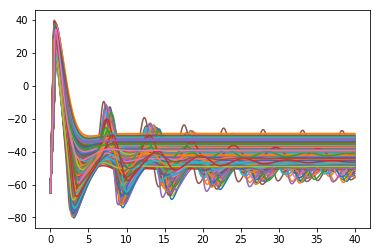

In [20]:
plt.plot(t,np.transpose(voltages));

In [89]:
np.shape(voltages)

(2187, 1201)

In [52]:
ind = []
for v in vv:
    for i,vo in enumerate(v):
        if vo > 0:
            ind.append(i)
            break


In [53]:
np.mean(ind)*0.025

0.3955761316872428

In [54]:
import pandas as pd

In [55]:
col_names = [str(round(tt,3)) for tt in t] 

In [92]:
col_names = [str(round(tt,3)) for tt in t] # Creates the columnames 
voltage_data = pd.DataFrame(voltages,columns=col_names)

In [93]:
voltage_data.head()

,0.0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,...,29.775,29.8,29.825,29.85,29.875,29.9,29.925,29.95,29.975,30.0
0,-65.0,-60.954714,-56.980118,-53.070838,-49.219525,-45.414479,-41.636254,-37.852880,-34.013587,-30.041247,...,-49.446541,-49.271716,-49.095793,-48.918674,-48.740256,-48.560431,-48.379088,-48.196112,-48.011381,-47.824772
1,-65.0,-60.835706,-56.752125,-52.742687,-48.798476,-44.905465,-41.040512,-37.165679,-33.220703,-29.113807,...,-48.974197,-48.834353,-48.693812,-48.552539,-48.410495,-48.267640,-48.123935,-47.979336,-47.833800,-47.687282
2,-65.0,-61.612491,-58.272117,-54.975051,-51.716353,-48.488734,-45.280869,-42.075089,-38.844320,-35.548249,...,-40.688692,-40.348294,-39.998822,-39.639931,-39.271275,-38.892522,-38.503350,-38.103455,-37.692557,-37.270409
3,-65.0,-61.223215,-57.509906,-53.854608,-50.250274,-46.686394,-43.146379,-39.603928,-36.018259,-32.328328,...,-44.000309,-43.991871,-43.982730,-43.972899,-43.962387,-43.951207,-43.939371,-43.926891,-43.913778,-43.900046
4,-65.0,-61.371848,-57.799068,-54.276698,-50.798181,-47.353592,-43.927150,-40.493751,-37.014324,-33.429981,...,-46.491169,-46.280784,-46.066940,-45.849446,-45.628101,-45.402694,-45.173006,-44.938805,-44.699850,-44.455885


In [99]:
parameter_space = []
for p in param_space:
    parameter_space.append(list(p.values()))
    
parameter_space = np.array(parameter_space)

In [100]:
parameter_df = pd.DataFrame(parameter_space,columns=names)

In [101]:
parameter_df.head()

,Cm,gbar_Na,gbar_K,gbar_L,E_Na,E_K,E_l
0,50.956976,-45.179217,-89.851847,36.487222,118.599866,0.289651,0.904649
1,58.096844,-45.907460,-81.152005,38.331755,117.311377,0.343236,0.900498
2,43.847200,-63.954605,-88.073097,28.895365,128.391236,0.326089,1.060774
3,44.186560,-60.722576,-70.965812,42.174006,135.140206,0.268299,0.983463
4,49.952393,-60.271667,-84.075049,33.778070,133.652320,0.300837,0.999476


In [148]:
parameter_df.shape

(2187, 7)

In [150]:
voltage_data.shape

(2187, 1601)